In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.model import SimpleModel
from src.model_utils import evaulate_model, train_model
from src.visualize_utils import plot_cm, get_avg_fold

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [3]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,-1.0,-1.0,71.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,-1.0,-1.0,-1.0,1,30,0,1,186.0,55,30.0


In [4]:
non_target_gestures = full_df[full_df['sequence_type'] == 'Non-Target']['gesture'].unique()
target_gestures = full_df[full_df['sequence_type'] == 'Target']['gesture'].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]
filtered_df.loc[filtered_df['sequence_type'] == 'Non-Target', 'gesture'] = non_target_gestures[0]
agg_recipe = {
    "gesture": ["first"],
    "subject": ['first'],
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
}

filtered_df = filtered_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df['subject']
encoder = load_encoder(encoder_path, target_df)

target_tensor = torch.tensor(encoder.transform(target_df), dtype=torch.long)
features_tensor = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

In [5]:
batch_size = 64
n_epochs = 50
n_splits = 5

gkf = GroupKFold(n_splits)

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_tensor, y=target_tensor, groups=subject_df)): # type: ignore
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = features_tensor[test_indices], target_tensor[test_indices]
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

/tmp/ipykernel_12098/3563300875.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.7808521039345686
20 - loss_avg: 1.307672465548796
40 - loss_avg: 1.2470274760442621


/tmp/ipykernel_12098/3563300875.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.7735638980771982
20 - loss_avg: 1.3592939750820983
40 - loss_avg: 1.294117516746708


/tmp/ipykernel_12098/3563300875.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.7881302272572237
20 - loss_avg: 1.3415734534170114
40 - loss_avg: 1.2818136484015221


/tmp/ipykernel_12098/3563300875.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.804830201700622
20 - loss_avg: 1.3336954905706293
40 - loss_avg: 1.2754489317828535


/tmp/ipykernel_12098/3563300875.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


0 - loss_avg: 1.8297569108944314
20 - loss_avg: 1.343494455019633
40 - loss_avg: 1.287373466234581


macro: 0.31, binary: 0.81, competition: 0.56


,precision,recall,f1-score,support
Above ear - pull hair,0.282759,0.320312,0.300366,128.000000
Cheek - pinch skin,0.369863,0.212598,0.270000,127.000000
Eyebrow - pull hair,0.184211,0.109375,0.137255,128.000000
Eyelash - pull hair,0.325581,0.328125,0.326848,128.000000
Forehead - pull hairline,0.309859,0.343750,0.325926,128.000000
Forehead - scratch,0.316770,0.398438,0.352941,128.000000
Neck - pinch skin,0.262295,0.125000,0.169312,128.000000
Neck - scratch,0.185484,0.179688,0.182540,128.000000
Write name on leg,0.668056,0.791118,0.724398,608.000000
accuracy,0.453096,0.453096,0.453096,0.453096


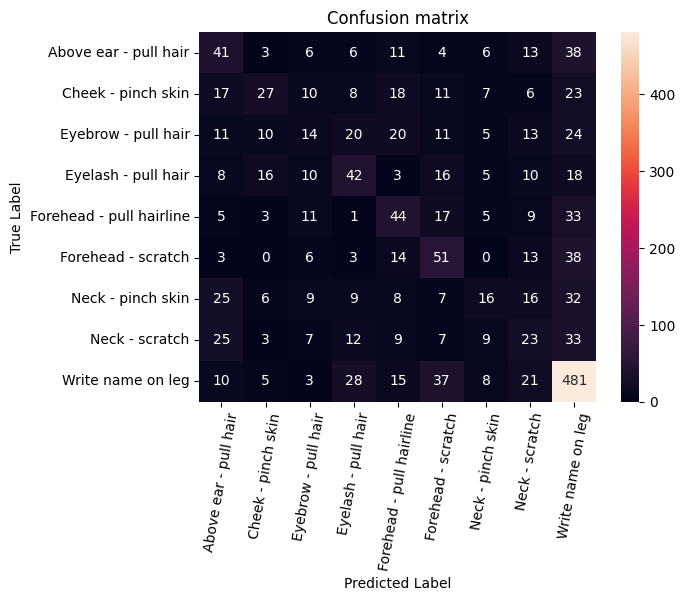

In [7]:
# fold = get_avg_fold(folds_score)
fold = folds_score[0]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

In [202]:
# final train model
n_epochs = 400
model = SimpleModel(n_classes)

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
